In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from tqdm.auto import tqdm
from plot_funcs import *

In [2]:
plt.style.use('default')
plt.style.use('thesis_style.mplstyle') # only activate for thesis, adjust height


In [6]:
a_max = 1.
a_min = 0.
na = 401
alpha, dalpha = np.linspace(a_min, a_max, num=na, retstep=True)
r_d = 0.25
r_b = 0.5
p_l = 1e-8
T_d = 700
T_p = 5e6
p_d = T_d * p_l
p_p = T_p * p_l
p_mut = 1 - (1 - p_d) * (1 - p_p)
p_pos = T_d / (T_d + T_p)
s_p = 0.001 * r_b
s_d = 0.2 * r_b

# mean and variance for double exponential distribution (without truncation)
mean_mut_effect = p_pos * s_d - (1 - p_pos) * s_p
var = p_pos * s_d**2 + (1 - p_pos) * s_p**2

mu = np.linspace(-(a_max-a_min), a_max-a_min, 2 * na - 1)
tmax = 40000
dens0 = 1 - r_d / r_b

# K = 500
Ncrit_alt = T_p * (s_p / r_b) / T_d / (s_d/r_b)**2
Ncrit = (T_p * r_b * s_p) / (T_d * s_d**2)
mucrit = s_d / T_p / r_b
K = np.ceil(Ncrit * 4)  # check mcfarland theory

In [8]:
Ncrit, Ncrit_alt

(178.57142857142853, 178.57142857142856)

In [4]:
files = ['lgca_cancerdfe_4_isolated_05Ncrit.pickle', 'lgca_cancerdfe_4_isolated_10Ncrit.pickle',
         'lgca_cancerdfe_4_isolated_20Ncrit.pickle']
densities = []
mean_props = []
std_mean_props = []
for i, file in tqdm(enumerate(files)):
    with open(file, 'rb') as f:
        lgca = pkl.load(f)

    tmax = len(lgca.dens_t)
    densities.append(lgca.dens_t.reshape((tmax, -1)))
    prop = np.array(lgca.props['r_b'])
    cells_t = lgca.nodes_t.sum(-1).reshape((tmax, -1))
    prop_t = [[prop[cells] if len(cells) > 0 else np.array([np.nan]) for cells in cells_t[t]] for t in range(tmax)]
    mean_prop_t = np.array(
        [[np.mean(prop) if len(prop) > 0 else np.nan for prop in prop_t[t]] for t in range(tmax)])
    std_mean_prop_t = np.array(
        [[np.std(prop, ddof=1, axis=-1) if len(prop) > 1 else np.nan for prop in prop_t[t]] for t in range(tmax)])
    mean_props.append(mean_prop_t)
    std_mean_props.append(std_mean_prop_t)
    # var_prop_t = np.array([np.var(prop, ddof=1) if len(prop) > 0 else np.nan for prop in prop_t])


0it [00:00, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


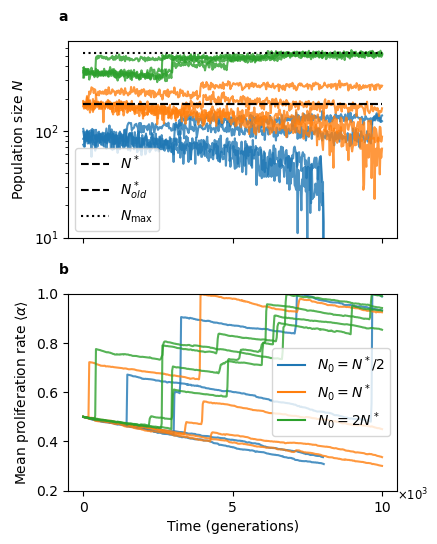

In [7]:
from matplotlib.ticker import FuncFormatter
golden_ratio = (np.sqrt(5) + 1.0) / 2.0
# get default figsize
wi, le = plt.rcParams['figure.figsize']
wi = 0.7 * wi
le = wi / golden_ratio * 2

# creat figure with 3 subplots in 1 column
fig, ax = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(wi, le))

plt.sca(ax[0])
skip = 100
Nmax = K * (1 - r_d)
x = np.arange(tmax+1)[::skip] / 4
for i, density in enumerate(densities):
    plt.plot(x, density[::skip], c='C{}'.format(i), alpha=.8)

plt.yscale('log')
plt.ylim(10, 1.3*Nmax)
plt.plot([0, tmax/4], [Ncrit, Ncrit], 'k--', label='$N^*$')
plt.plot([0, tmax/4], [Ncrit_alt, Ncrit_alt], 'k--', label='$N^*_{old}$')
plt.plot([0, tmax/4], [Nmax, Nmax], 'k:', label=r'$N_{\max}$')
plt.legend()

plt.ylabel('Population size $N$')

plt.sca(ax[1])
for i, alpha in enumerate(mean_props):
    plt.plot(x, alpha[::skip], c='C{}'.format(i), alpha=.8)

plt.ylabel(r'Mean proliferation rate $\langle\alpha\rangle$')
plt.ylim(.2, 1)
# plt.sca(ax[2])
# skip= 1
# Nmax = K * (1 - r_d)
# x = np.arange(tmax)[::skip] / 4
# for i, alpha in enumerate(std_mean_props):
#     plt.plot(x, alpha[::skip], c='C{}'.format(i), alpha=.8)
# 
plt.xlabel('Time (generations)')
# plt.ylabel(r'STD $\sqrt{\left\langle\Delta\alpha^2\right\rangle}$')
# # plt.yscale('log')
# plt.ylim(0, .2)
# plt.xlim(0)

# create a function to format the y axis labels
# def format_y_ticks(tick_val, pos):
#     return f'{tick_val * 10**2 :.1f}'
# 
# # apply the formatter
# ax[-1].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
# 
# # Add scale next to the y-axis
# ax[-1].text(-0.1, 1.0, r'$\times 10^{-2}$', transform=ax[-1].transAxes, fontsize='small')
# ax[-1].set_yticks([0.0, 0.1, 0.2])
ax[-1].set_xticks([0, 5000, 10000], [0, 5, 10])
ax[-1].text(1.0, -0.05, r'$\times 10^{3}$', transform=ax[-1].transAxes, fontsize='small')

leg = plt.legend()
lines, labels = plt.gca().get_legend_handles_labels()
lines += [plt.Line2D([0], [0], c=c) for c in ['C0', 'C1', 'C2']]
labels += ['$N_0 = N^*/2$', '$N_0 = N^*$', '$N_0 = 2 N^*$']
plt.legend(lines, labels, loc='best')
# plt.ylim(0, 0.02)
label_axes(ax)
plt.tight_layout()
# plt.savefig('mullersratchet_N_nostd.pdf')